In [1]:
%load_ext autoreload
%autoreload
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from scipy import stats

from MLP.mlp_regression import mlp_regression, model_validation, mlp_prediction, mlp_prediction_error, mlp_train_graph, errorDist, mlp_train_multi_graph, mlp_train_multi_graph_comb, mlp_train_multi_3dgraph_comb
from MLP.utils import combineArray, multiArraySort, data_loader_from_csv, data_loader_pathloss, describeData, data_loader_pathloss_with_freq

pd.set_option('display.max_rows', 999)
pd.set_option('precision', 5)

In [2]:
%load_ext autoreload
%autoreload
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
import scipy.stats
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits import mplot3d

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from scipy import stats

from MLP.mlp_regression import mlp_regression, model_validation, mlp_prediction, mlp_prediction_error, mlp_train_graph, errorDist, mlp_train_multi_graph, mlp_train_multi_graph_comb, mlp_train_multi_3dgraph_comb
from MLP.utils import data_loader_pathloss, describeData, data_loader_pathloss_with_freq
from GMM.utils import gp_train_multi_3dgraph, gp_ann_train_multi_3dgraph, gpCompareDiffDim, mergeSet

pd.set_option('display.max_rows', 999)
pd.set_option('precision', 5)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
%autoreload
X_train_m_400, X_val_m_400, y_train_m_400, y_val_m_400, X_train_s_400, X_val_s_400, y_train_s_400, y_val_s_400 = data_loader_from_csv('data/PLdata_iksan_wt_400.csv', np.log10(400), 'dist' ,3, testRatio=0.8)
X_train_m_1399, X_val_m_1399, y_train_m_1399, y_val_m_1399, X_train_s_1399, X_val_s_1399, y_train_s_1399, y_val_s_1399 = data_loader_from_csv('data/PLdata_iksan_wt_1399.csv', np.log10(1399),'dist', 3, testRatio=0.8)
X_train_m_2249, X_val_m_2249, y_train_m_2249, y_val_m_2249, X_train_s_2249, X_val_s_2249, y_train_s_2249, y_val_s_2249 = data_loader_from_csv('data/PLdata_iksan_wt_2249.csv', np.log10(2249),'dist', 3, testRatio=0.8)

X_train_m = combineArray(X_train_m_400, X_train_m_1399, X_train_m_2249)
y_train_m = combineArray(y_train_m_400, y_train_m_1399, y_train_m_2249)
X_val_m = combineArray(X_val_m_400, X_val_m_1399, X_val_m_2249)
y_val_m = combineArray(y_val_m_400, y_val_m_1399, y_val_m_2249)

X_train_s = combineArray(X_train_s_400, X_train_s_1399, X_train_s_2249)
y_train_s = combineArray(y_train_s_400, y_train_s_1399, y_train_s_2249)
X_val_s = combineArray(X_val_s_400, X_val_s_1399, X_val_s_2249)
y_val_s = combineArray(y_val_s_400, y_val_s_1399, y_val_s_2249)

X_train_m_400

original: 109210
filtered: 13240
Covariance Matrix
           dist      ploss   height
dist    0.66829    6.46991  0.01753
ploss   6.46991  199.79524  0.18395
height  0.01753    0.18395  0.02862
--------------------------------------------------
Preprocessing <data/PLdata_iksan_wt_400.csv>...Total 13240
- moving type: total: 9669 (training: 1933/validation: 7736)
- stationary type: total: 3571 (training: 714/validation: 2857)
original: 109060
filtered: 13178
Covariance Matrix
           dist      ploss   height
dist    0.66230    7.64274  0.01745
ploss   7.64274  281.14171  0.25075
height  0.01745    0.25075  0.02875
--------------------------------------------------
Preprocessing <data/PLdata_iksan_wt_1399.csv>...Total 13178
- moving type: total: 9607 (training: 1921/validation: 7686)
- stationary type: total: 3571 (training: 714/validation: 2857)
original: 108873
filtered: 13109
Covariance Matrix
           dist      ploss   height
dist    0.65516    7.31038  0.01735
ploss   7.31038 

array([[2.24150665, 2.60205999],
       [2.24225171, 2.60205999],
       [2.24281273, 2.60205999],
       ...,
       [3.4765125 , 2.60205999],
       [3.47680091, 2.60205999],
       [3.47686944, 2.60205999]])

In [8]:
%autoreload
dataX_m = list()
dataY_m = list()
dataX_m.append(X_train_m_400)
dataY_m.append(y_train_m_400)
dataX_m.append(X_train_m_1399)
dataY_m.append(y_train_m_1399)
dataX_m.append(X_train_m_2249)
dataY_m.append(y_train_m_2249)

In [9]:
X = X_train_m
y = y_train_m

# Instantiate a Gaussian Process model
# kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
# kernel = 1.0 * RBF(length_scale=100.0, length_scale_bounds=(1e-2, 1e3)) \
#    + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))
# gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
kernel = 1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)) \
    + WhiteKernel(noise_level=1e-5, noise_level_bounds=(1e-10, 1e+1))
gp_ma = GaussianProcessRegressor(kernel=kernel,
                              alpha=0.0)
# Fit to data using Maximum Likelihood Estimation of the parameters
gp_ma.fit(X, y)

filename = 'model/gp_iksan_wt_3d_model.sav'
pickle.dump(gp_ma, open(filename, 'wb'))

<Iksan - Winter> Gaussian Process (dist<=3000m)


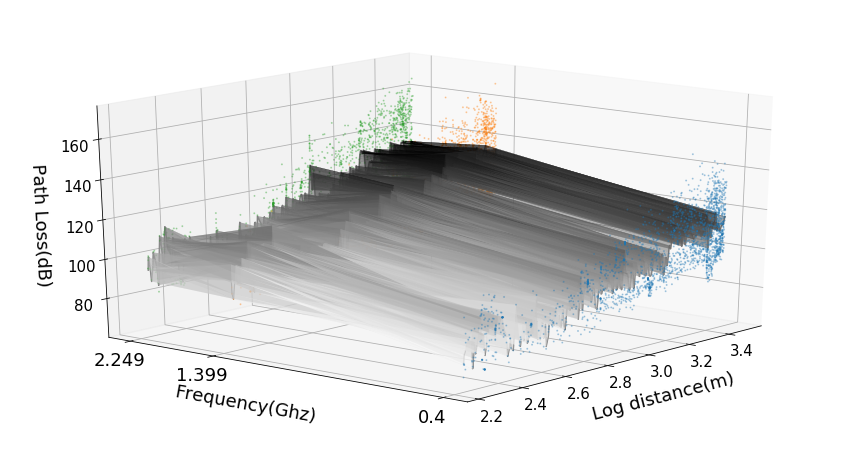

RMSE(dB),train error,val error
0.4Ghz,10.99536,11.93085
1.399Ghz,12.70828,14.09742
2.249Ghz,13.04950,14.64160
Overall,12.27951,13.60112


In [11]:
%autoreload
model = None
model = pickle.load(open('model/gp_iksan_wt_3d_model.sav', 'rb'))

print("<Iksan - Winter> Gaussian Process (dist<=3000m)")
mlp_train_multi_3dgraph_comb(model, dataX_m, dataY_m, X_train_m, ['0.4', '1.399','2.249'])

stat = np.array([mlp_prediction_error(model,X_train_m_400, y_train_m_400),mlp_prediction_error(model,X_val_m_400, y_val_m_400),
                 mlp_prediction_error(model,X_train_m_1399, y_train_m_1399),mlp_prediction_error(model,X_val_m_1399, y_val_m_1399),
                 mlp_prediction_error(model,X_train_m_2249, y_train_m_2249),mlp_prediction_error(model,X_val_m_2249, y_val_m_2249),
                 mlp_prediction_error(model,X_train_m, y_train_m), mlp_prediction_error(model,X_val_m, y_val_m)])

(pd.DataFrame(stat.reshape((4,2)),index=pd.Index(['0.4Ghz','1.399Ghz','2.249Ghz', 'Overall']), columns=pd.Index(['train error','val error'],name='RMSE(dB)')))